<a href="https://colab.research.google.com/github/DeaDurro/Thesis/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


# Load production data
production_data = pd.read_csv('/content/drive/MyDrive/Randomproduction_data.csv', delimiter=';')



# Convert ','-separated decimal numbers to float (if needed)
production_data = production_data.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

# Convert 'Status' column to binary values
production_data['Status'] = production_data['Status'].apply(lambda x: 1 if x == 'Not Okay' else 0)

# Convert all columns to numeric
production_data = production_data.apply(pd.to_numeric, errors='coerce')




In [22]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
production_data_imputed = pd.DataFrame(imputer.fit_transform(production_data.iloc[:, 2:-1]), columns=production_data.columns[2:-1])

# Concatenate the 'Record_ID', 'Date', and 'Status' columns with the imputed data
# In summary, concatenating these columns back to the imputed data ensures that we maintain
# the integrity of the original data while performing preprocessing steps.
#This will help us when building models and analyzing the results in later steps.
production_data_imputed = pd.concat([production_data[['Record_ID', 'Date']], production_data_imputed, production_data['Status']], axis=1)

# Identify and handle outliers (You can customize this step based on your data characteristics)
# Here, we will remove rows where any column value is more than 3 standard deviations away from the mean
outliers_removed = production_data_imputed[(np.abs(stats.zscore(production_data_imputed.iloc[:, 2:-1])) < 3).all(axis=1)]

# Standardize/normalize measurements using StandardScaler
scaler = StandardScaler()
production_data_scaled = scaler.fit_transform(outliers_removed.iloc[:, 2:-1])  # Exclude 'Record_ID', 'Date', and 'Status'

# Create a new DataFrame with scaled values
production_data_scaled_df = pd.DataFrame(production_data_scaled, columns=outliers_removed.columns[2:-1])

# Add the 'Record_ID', 'Date', and 'Status' columns back to the scaled DataFrame
production_data_scaled_df[['Record_ID', 'Date']] = outliers_removed[['Record_ID', 'Date']]
production_data_scaled_df['Status'] = outliers_removed['Status']

# Save the preprocessed data to a new CSV file
production_data_scaled_df.to_csv('preprocessed_production_data.csv', index=False)



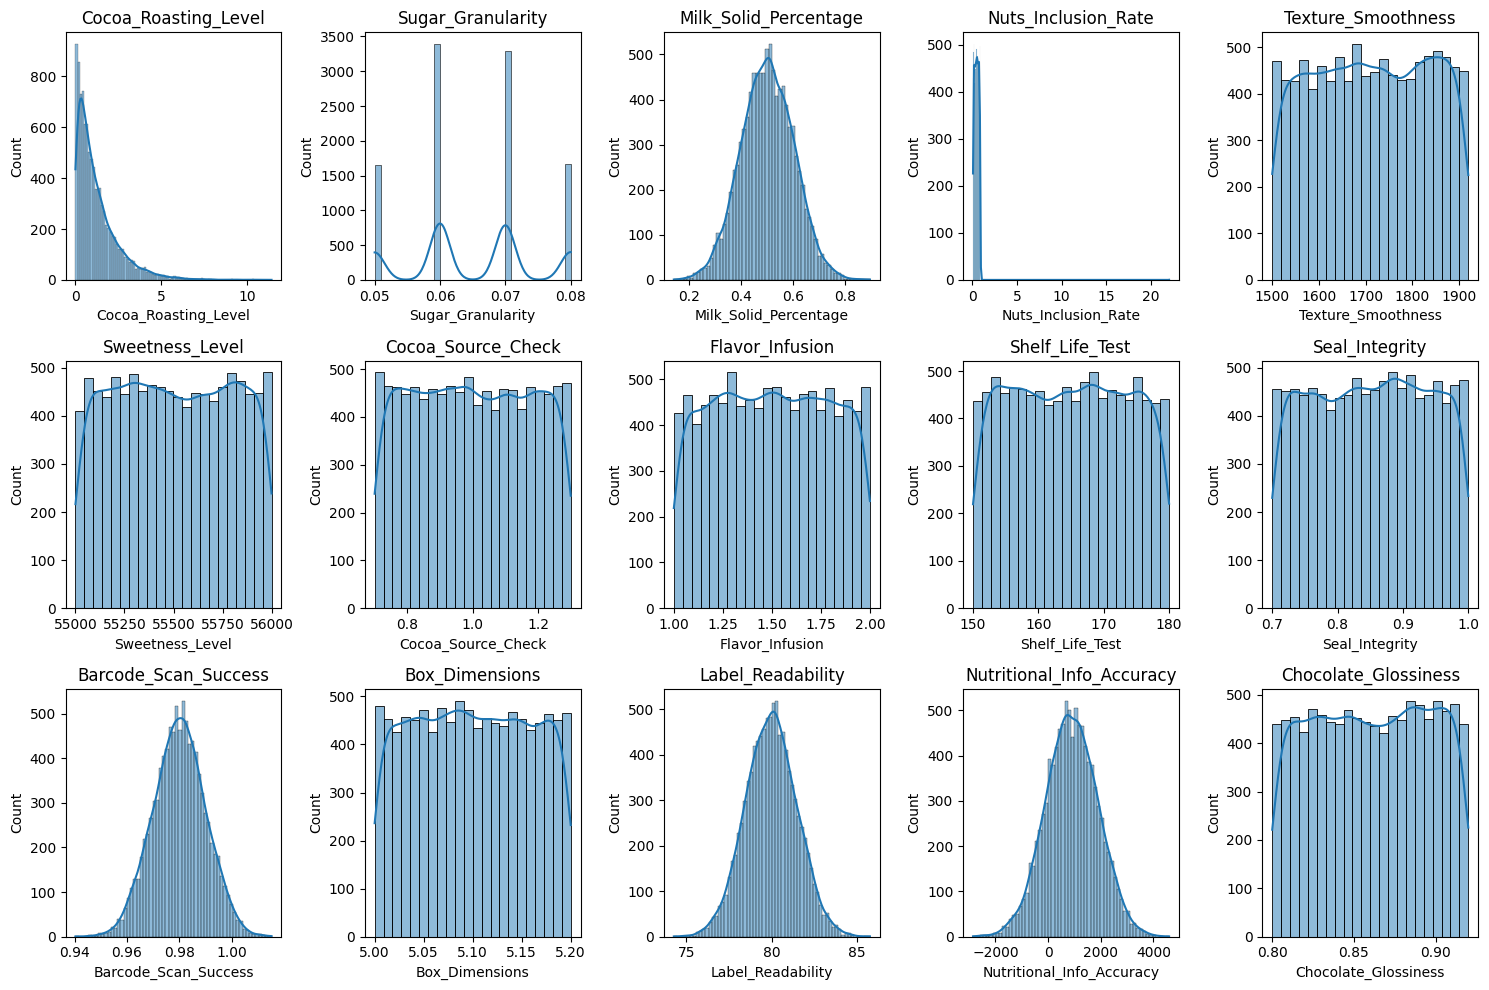

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


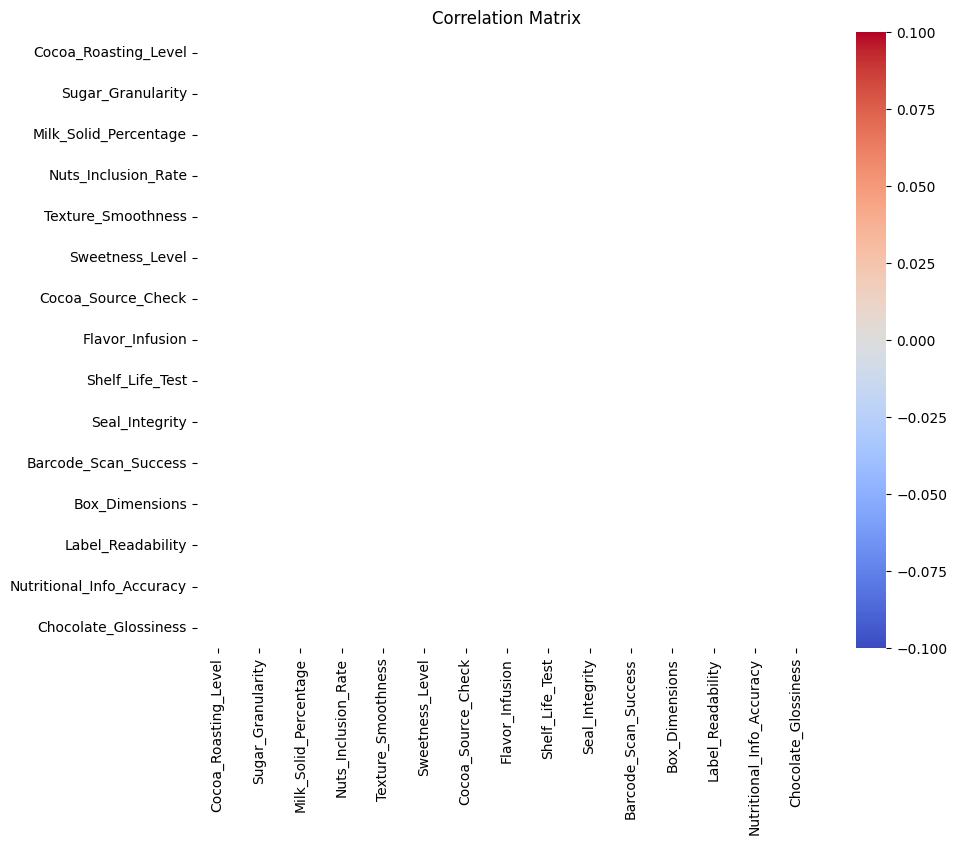

In [23]:
# Analyze the distribution of measurements for each station
plt.figure(figsize=(15, 10))
for i, col in enumerate(production_data_imputed.columns[2:-1], 1):
    plt.subplot(3, 5, i)
    sns.histplot(data=production_data_imputed, x=col, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Identify patterns in "not okay" instances
not_okay_patterns = production_data_imputed[production_data_imputed['Status'] == 'Not Okay']

# Determine correlations between different stations
correlation_matrix = not_okay_patterns.iloc[:, 2:-1].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


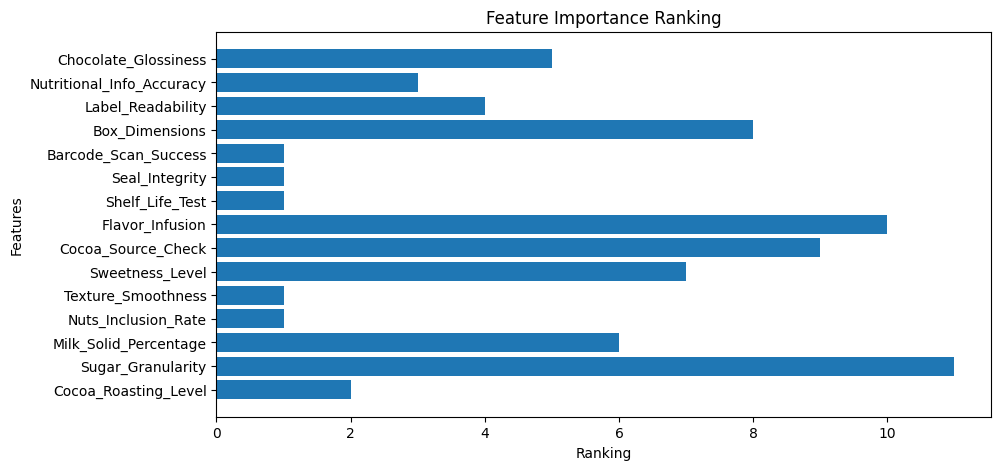

In [24]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Separate features and target variable
X = production_data_imputed.iloc[:, 2:-1]  # Exclude 'Record_ID', 'Date', and 'Status'
y = production_data_imputed['Status']

# Initialize a random forest classifier
clf = RandomForestClassifier()

# Initialize RFE with the classifier and number of desired features
num_features_to_select = 5
rfe = RFE(clf, n_features_to_select=num_features_to_select)

# Fit RFE on the data
rfe.fit(X, y)

# Get the ranking of features
feature_ranking = rfe.ranking_

# Visualize feature rankings
plt.figure(figsize=(10, 5))
plt.barh(X.columns, feature_ranking)
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import eli5
from sklearn.metrics import precision_score, recall_score, f1_score

# Separate features and target variable
X = production_data_imputed.iloc[:, 2:-1]  # Exclude 'Record_ID', 'Date', and 'Status'
y = production_data_imputed['Status']

unique_labels_test = set(y_test)
unique_labels_pred = set(y_pred)

print("Unique labels in y_test:", unique_labels_test)
print("Unique labels in y_pred:", unique_labels_pred)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a random forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


report = classification_report(y_test, y_pred, zero_division='warn')
print("Classification Report:\n", report)

# Explain model predictions using eli5
explanation = eli5.show_weights(clf, feature_names=X.columns.tolist())
display(explanation)


Unique labels in y_test: {0, 1}
Unique labels in y_pred: {0}
Accuracy: 0.928
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1856
           1       0.00      0.00      0.00       144

    accuracy                           0.93      2000
   macro avg       0.46      0.50      0.48      2000
weighted avg       0.86      0.93      0.89      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weight,Feature
0.0736 ± 0.0259,Texture_Smoothness
0.0728 ± 0.0279,Seal_Integrity
0.0707 ± 0.0251,Barcode_Scan_Success
0.0707 ± 0.0222,Nutritional_Info_Accuracy
0.0701 ± 0.0267,Cocoa_Roasting_Level
0.0700 ± 0.0261,Box_Dimensions
0.0697 ± 0.0271,Milk_Solid_Percentage
0.0696 ± 0.0253,Label_Readability
0.0692 ± 0.0203,Sweetness_Level
0.0691 ± 0.0263,Chocolate_Glossiness


       Rework_Time  Rework_Cost
count   802.000000   802.000000
mean     20.026185    12.359102
std       6.098285     4.607785
min      10.000000     5.000000
25%      15.000000     8.000000
50%      20.000000    12.000000
75%      25.000000    16.000000
max      30.000000    20.000000


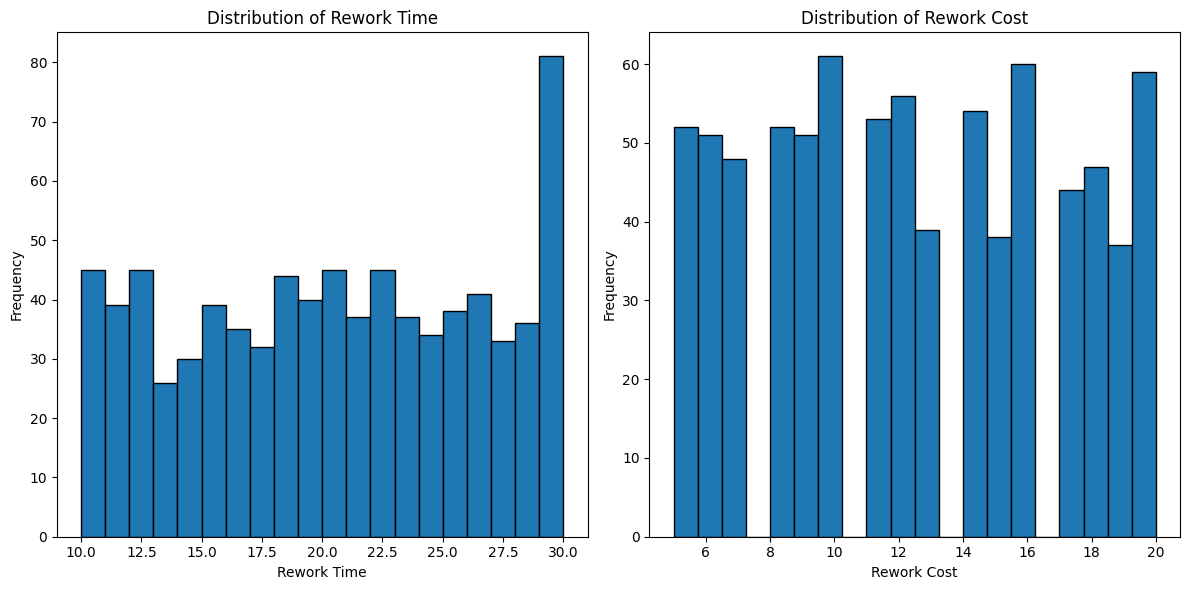

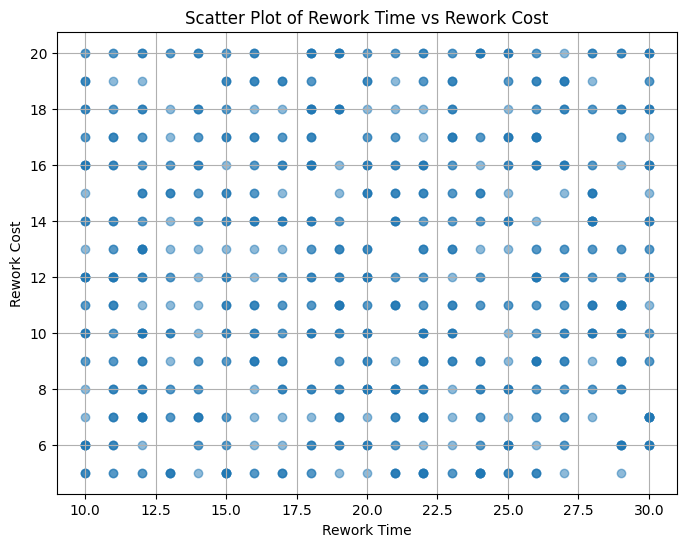

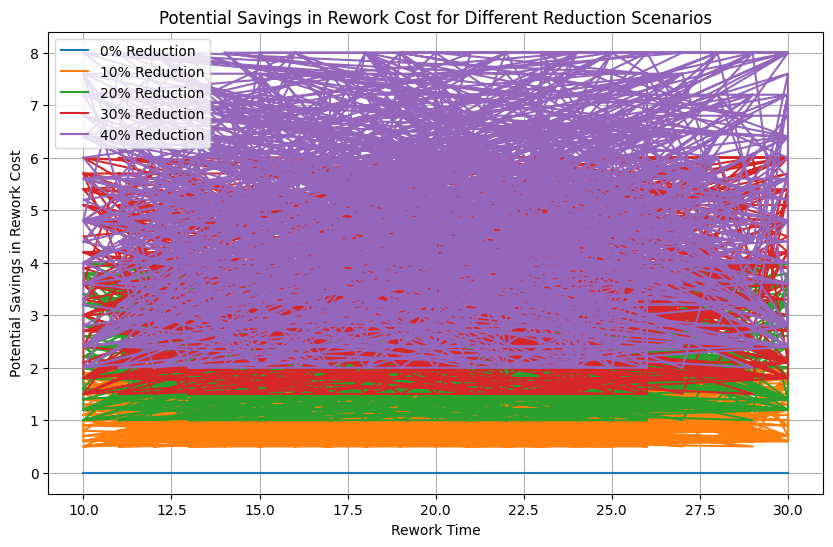

             Rework_Time  Rework_Cost
Rework_Time     1.000000     0.018547
Rework_Cost     0.018547     1.000000
       Rework_Time  Rework_Cost
count   802.000000   802.000000
mean     20.026185    12.359102
std       6.098285     4.607785
min      10.000000     5.000000
25%      15.000000     8.000000
50%      20.000000    12.000000
75%      25.000000    16.000000
max      30.000000    20.000000


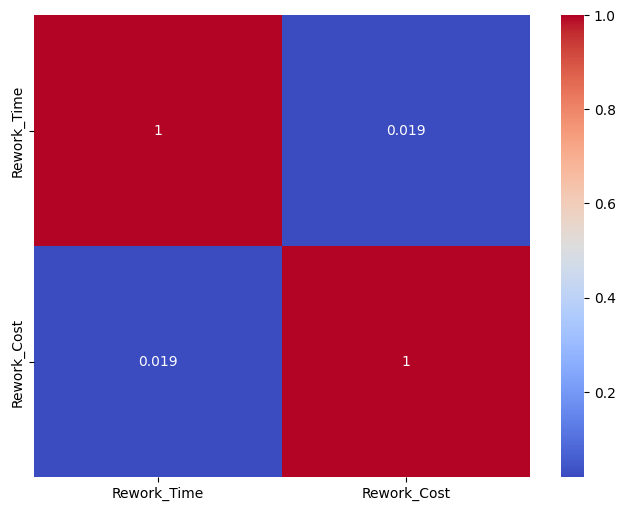

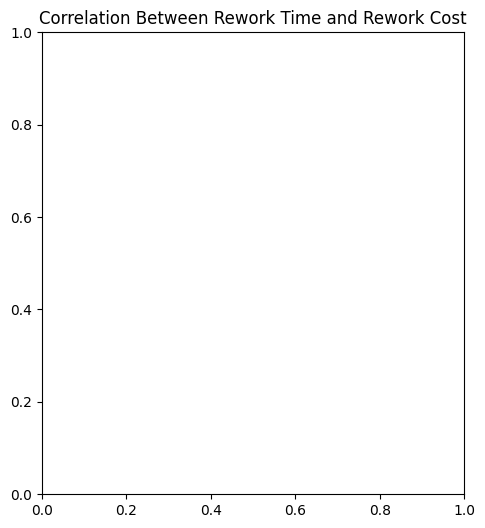

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data
data = pd.read_csv('/content/drive/MyDrive/Randomrework_data.csv')

print(data.describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data['Rework_Time'], bins=20, edgecolor='k')
plt.xlabel('Rework Time')
plt.ylabel('Frequency')
plt.title('Distribution of Rework Time')

plt.subplot(1, 2, 2)
plt.hist(data['Rework_Cost'], bins=20, edgecolor='k')
plt.xlabel('Rework Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Rework Cost')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data['Rework_Time'], data['Rework_Cost'], alpha=0.5)
plt.xlabel('Rework Time')
plt.ylabel('Rework Cost')
plt.title('Scatter Plot of Rework Time vs Rework Cost')
plt.grid()
plt.show()


# Define the percentage reduction scenarios
percentage_reduction = [0, 10, 20, 30, 40]

# Simulate scenarios and calculate potential savings in rework cost
potential_savings = {}
for reduction in percentage_reduction:
    potential_savings[reduction] = data['Rework_Cost'] * reduction / 100

# Plot potential savings for each scenario
plt.figure(figsize=(10, 6))
for reduction, savings in potential_savings.items():
    plt.plot(data['Rework_Time'], savings, label=f'{reduction}% Reduction')
plt.xlabel('Rework Time')
plt.ylabel('Potential Savings in Rework Cost')
plt.title('Potential Savings in Rework Cost for Different Reduction Scenarios')
plt.legend()
plt.grid()
plt.show()

correlation_matrix = data[['Rework_Time', 'Rework_Cost']].corr()
print(correlation_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data
data = pd.read_csv('/content/drive/MyDrive/Randomrework_data.csv')

print(data.describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)


plt.title('Correlation Between Rework Time and Rework Cost')
plt.show()


# Create a DataFrame with potential savings data
savings_data = pd.DataFrame(potential_savings)

# Export the DataFrame to a CSV file
savings_data.to_csv('potential_savings.csv', index=False)

In [27]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the rework_data
data = pd.read_csv('/content/drive/MyDrive/Randomrework_data.csv')

# Prepare the independent variable (add constant for intercept)
X = sm.add_constant(np.zeros(data.shape[0]))  # Adding a column of zeros for the constant term

# Perform linear regression for each dependent variable
dependent_vars = ['Rework_Time', 'Rework_Cost']
for dep_var in dependent_vars:
    y = data[dep_var]
    model = sm.OLS(y, X).fit()

    print(f"Dependent Variable: {dep_var}")
    print(model.summary())
    print('\n')

    # Simulate scenarios for the current dependent variable
    savings_scenarios = np.arange(-10, 11, 1)
    print(f"Simulating scenarios for {dep_var}:\n")
    for savings in savings_scenarios:
        simulated_rework = model.predict([1, savings])
        print(f"Savings: {savings:.2f}, Simulated {dep_var}: {simulated_rework[0]:.2f}")
    print('\n')



Dependent Variable: Rework_Time
                            OLS Regression Results                            
Dep. Variable:            Rework_Time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 19 Aug 2023   Prob (F-statistic):                nan
Time:                        20:16:08   Log-Likelihood:                -2587.5
No. Observations:                 802   AIC:                             5177.
Df Residuals:                     801   BIC:                             5182.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.026

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [28]:
# Create a DataFrame with test data and predictions
results_df = pd.DataFrame({'Actual_Status': y_test, 'Predicted_Status': y_pred})

# Export the DataFrame to a CSV file
results_df.to_csv('model_predictions.csv', index=False)


In [29]:
import pandas as pd

# Load the data
data = pd.read_csv('/content/drive/MyDrive/Randomproduction_data.csv', delimiter=';')

# Convert ','-separated decimal numbers to float (if needed)
data = data.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

# Convert 'Status' column to binary values
data['Status'] = data['Status'].apply(lambda x: 1 if x == 'Not Okay' else 0)

# Convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Separate features and target variable
X = data.iloc[:, 2:-1]  # Exclude 'Record_ID', 'Date', and 'Status'

# Create a DataFrame with feature names and their rankings
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance_Rank': feature_ranking})

# Export the DataFrame to a CSV file
feature_importance_df.to_csv('feature_importance_ranking.csv', index=False)

In [30]:
# Create a DataFrame with feature names and their rankings
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance_Rank': feature_ranking})

# Export the DataFrame to a CSV file
feature_importance_df.to_csv('feature_importance_ranking.csv', index=False)


In [31]:
# Create a DataFrame with potential savings data
savings_data = pd.DataFrame(potential_savings)

# Export the DataFrame to a CSV file
savings_data.to_csv('potential_savings.csv', index=False)


In [33]:
from google.colab import files

files.download('model_predictions.csv')
files.download('feature_importance_ranking.csv')
files.download('potential_savings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>